In [2]:
from gensim.models import Word2Vec

model_paths = {
    '1920s': 'word2vec-movies_1921_1930-text.model',
    '1930s': 'word2vec-movies_1931_1940-text.model',
    '1940s': 'word2vec-movies_1941_1950-text.model',
    '1950s': 'word2vec-movies_1951_1960-text.model',
    '1960s': 'word2vec-movies_1961_1970-text.model',
    '1970s': 'word2vec-movies_1971_1980-text.model',
    '1980s': 'word2vec-movies_1981_1990-text.model',
    '1990s': 'word2vec-movies_1991_2000-text.model',
    '2000s': 'word2vec-movies_2001_2010-text.model',
}

models = {decade: Word2Vec.load(model_path) for decade, model_path in model_paths.items()}

In [3]:
asian_last_names = ['chung', 'liu', 'wong', 'huang', 'ng', 'hu', 'chu', 'chen', 'lin', 'liang', 'wang', 'wu', 'yang', 'tang', 'chang', 'hong', 'li'] #17 asian_last_names

white_last_names = ["smith", "johnson", "williams", "brown", "jones","miller", "davis", "garcia", "rodriguez", "wilson","martinez", "anderson", 
                           "taylor", "thomas", "martin", "jackson", "thompson"] #17 white_last_names

In [4]:
good_adjectives = ["intelligent", "diligent", "compassionate", "generous", "curious", "empathetic", "supportive", "kind", "creative", "reliable"]
bad_adjectives = ["cruel", "selfish", "greedy", "malicious", "deceitful", "ruthless", "arrogant", "vindictive", "negligent", "ignorant"]
neutral_adjectives = ["obedient", "independent", "reserved", "practical", "methodical", "objective", "skeptical", "traditional", "innovative", "pensive"]

In [5]:
#This part is the code from when I misunderstood the testing method described in the text; it's kept but probably won't be needed.
import numpy as np

adjective_bias_over_time = {}
adjectives  = good_adjectives

for decade, model in models.items():
    # Ensure the Asian last names are present in the model's vocabulary
    valid_names = [name for name in asian_last_names if name in model.wv.key_to_index]
    
    # If there are no valid names in the model, skip this decade
    if not valid_names:
        continue

    # Calculate the centroid vector for valid Asian last names
    asian_name_vectors = np.array([model.wv[name] for name in valid_names])
    asian_centroid = np.mean(asian_name_vectors, axis=0)
    
    # Normalize the centroid vector
    asian_centroid_norm = asian_centroid / np.linalg.norm(asian_centroid)
    
    for adj in adjectives:
        if adj in model.wv.key_to_index:
            # Get the normalized vector for the adjective
            adj_vector_norm = model.wv[adj] / np.linalg.norm(model.wv[adj])
            # Calculate cosine similarity manually
            similarity = np.dot(asian_centroid_norm, adj_vector_norm)
            adjective_bias_over_time.setdefault(adj, []).append((decade, similarity))



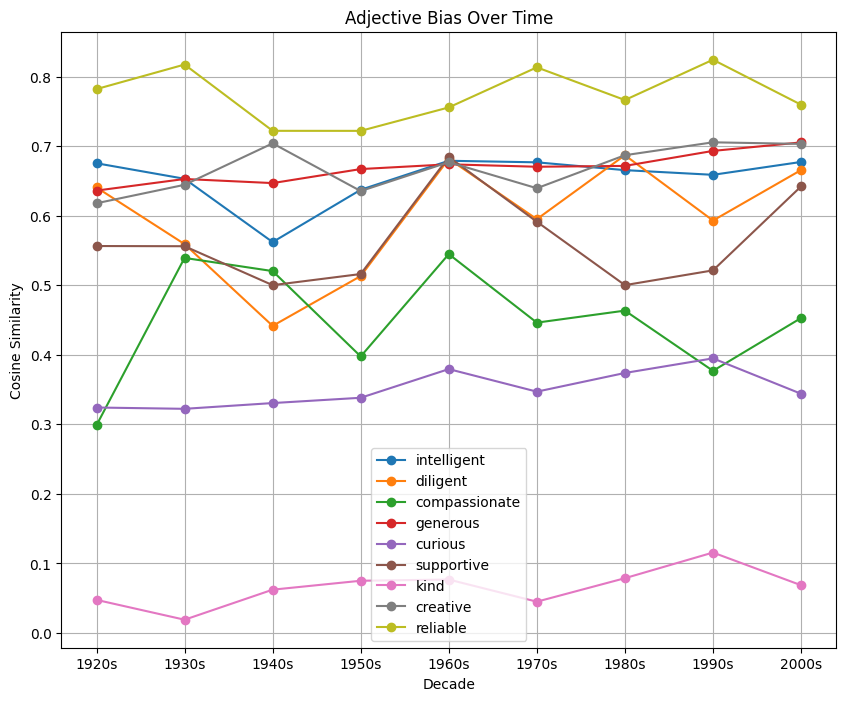

In [8]:
# same as above
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))


for adj, data in adjective_bias_over_time.items():
    decades, similarities = zip(*data)
    plt.plot(decades, similarities, marker='o', label=adj)


plt.title('Adjective Bias Over Time')
plt.xlabel('Decade')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)  

plt.show()


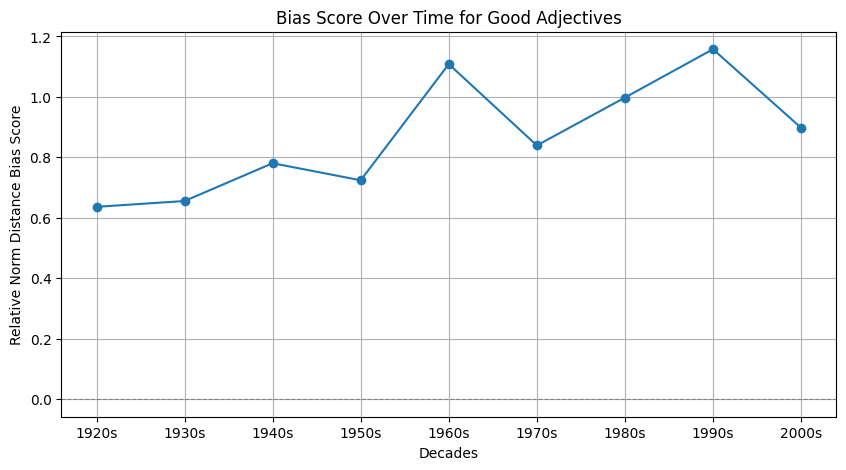

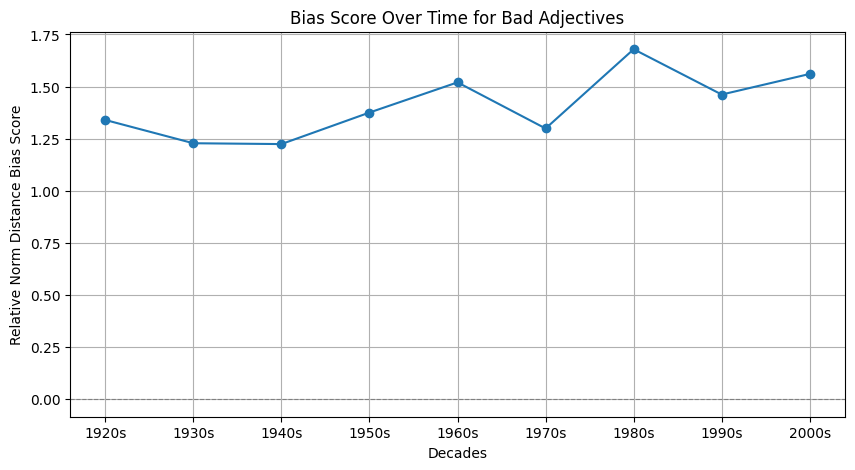

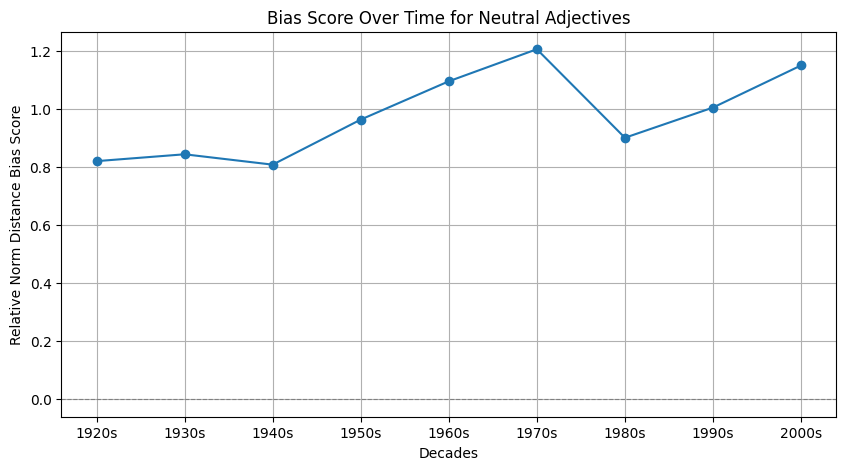

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

def calculate_centroids(model, name_list):
    valid_names = [name for name in name_list if name in model.wv.key_to_index]
    name_vectors = np.array([model.wv[name] for name in valid_names])
    centroid = np.mean(name_vectors, axis=0)
    return centroid / np.linalg.norm(centroid)

def compute_bias_scores(models, asian_centroids, white_centroids, adjectives):
    bias_scores = {decade: 0 for decade in models.keys()}
    for decade, model in models.items():
        for adj in adjectives:
            if adj in model.wv.key_to_index:
                adj_vector = model.wv[adj]
                distance_to_asian = np.linalg.norm(adj_vector - asian_centroids[decade])
                distance_to_white = np.linalg.norm(adj_vector - white_centroids[decade])
                bias_scores[decade] += (distance_to_white - distance_to_asian)
    return bias_scores

def plot_bias_over_time(bias_scores, title):
    decades = sorted(bias_scores.keys())
    scores = [bias_scores[decade] for decade in decades]

    plt.figure(figsize=(10, 5))
    plt.plot(decades, scores, marker='o')
    plt.title(f'Bias Score Over Time for {title}')
    plt.xlabel('Decades')
    plt.ylabel('Relative Norm Distance Bias Score')
    plt.axhline(0, color='grey', lw=0.8, linestyle='--')
    plt.grid(True)
    plt.show()

asian_centroids = {}
white_centroids = {}
for decade, model in models.items():
    asian_centroids[decade] = calculate_centroids(model, asian_last_names)
    white_centroids[decade] = calculate_centroids(model, white_last_names)

good_bias_scores = compute_bias_scores(models, asian_centroids, white_centroids, good_adjectives)
bad_bias_scores = compute_bias_scores(models, asian_centroids, white_centroids, bad_adjectives)
neutral_bias_scores = compute_bias_scores(models, asian_centroids, white_centroids, neutral_adjectives)

plot_bias_over_time(good_bias_scores, 'Good Adjectives')
plot_bias_over_time(bad_bias_scores, 'Bad Adjectives')
plot_bias_over_time(neutral_bias_scores, 'Neutral Adjectives')
